<a href="https://colab.research.google.com/github/ian-shade/Autotrader-Cars-Price-Predictions-ML/blob/main/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Colab/adverts.csv'
df = pd.read_csv(file_path)

# 1. Data/Domain Understanding and Processing


## 1.1 Inspection

In [4]:
df.head(3)

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [6]:
# MISSING VALUES AND DATA TYPES
variables = pd.DataFrame(columns=['Variable','Number of unique values','Number of nulls'])

for i, var in enumerate(df.columns):
    variables.loc[i] = [var, df[var].nunique(), df[var].isnull().sum()]

variables

,Variable,Number of unique values,Number of nulls
0,public_reference,402005,0
1,mileage,80634,127
2,reg_code,72,31857
3,standard_colour,22,5378
4,standard_make,110,0
5,standard_model,1168,0
6,vehicle_condition,2,0
7,year_of_registration,84,33311
8,price,30578,0
9,body_type,16,837


## 1.2 Fix obvious data quality issues and enhancments

Get Car Age

*   New Car will be 2023 to avoid Null **values**

*   Feature Engineer the Age out of year_of_registration.

*   I have assumed that the new car is 2023 model a two years higher than the latest Used car.



In [7]:
df['year_of_registration'] = df['year_of_registration'].fillna(2023) # Assumed new car as 2023
df['age'] = 2023 - df['year_of_registration'] # Assuming current year is 2022
df = df.drop('year_of_registration', axis=1) # Replaces with age

In [8]:
# Columns we can't make use off will be dropped
df = df.drop('reg_code', axis=1)
df = df.drop('standard_model', axis=1) #
df = df.drop('public_reference', axis=1)

## Target Feature Analysis

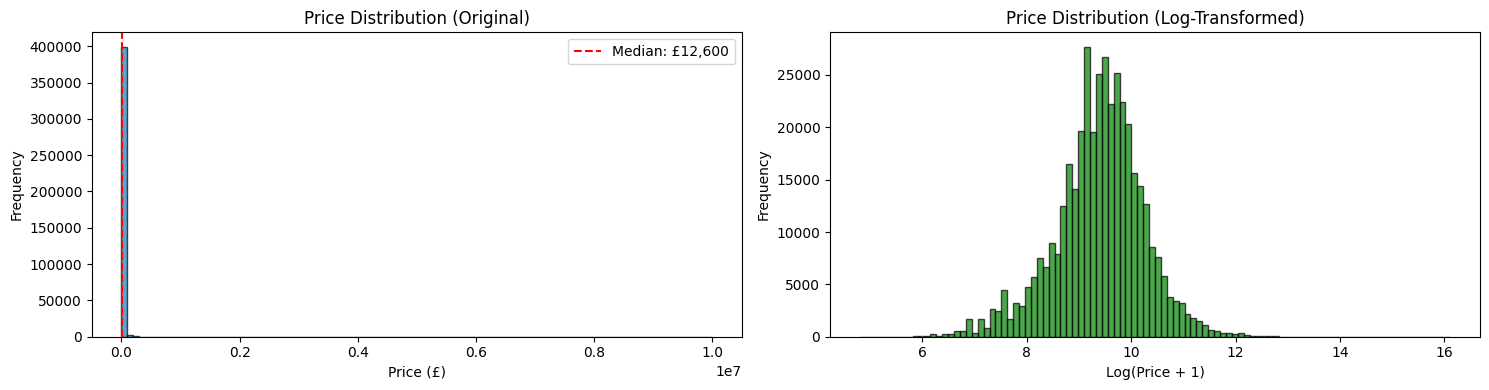


Skewness: 154.682 (high positive skew)
Kurtosis: 32182.673

**Interpretation:** Heavy right skew indicates most cars are lower-priced with
luxury outliers. Log transformation normalizes this for linear models.


In [9]:
# TARGET VARIABLE (PRICE) DISTRIBUTION

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Original price
axes[0].hist(df['price'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price (£)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution (Original)')
axes[0].axvline(df['price'].median(), color='r', linestyle='--',
                label=f'Median: £{df["price"].median():,.0f}')
axes[0].legend()

# Log-transformed
axes[1].hist(np.log1p(df['price']), bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution (Log-Transformed)')

plt.tight_layout()
plt.show()

print(f"\nSkewness: {df['price'].skew():.3f} (high positive skew)")
print(f"Kurtosis: {df['price'].kurtosis():.3f}")
print("\n**Interpretation:** Heavy right skew indicates most cars are lower-priced with")
print("luxury outliers. Log transformation normalizes this for linear models.")

In [10]:
price_cap = 350000   # Excludes super/luxury cars

df_clean = df[df['price'] < price_cap].copy()

# Print how much data was lost
lost_data = len(df) - len(df_clean)
print(f"Removed {lost_data} rows ({(lost_data/len(df))*100:.2f}%) as outliers.")
df = df_clean

Removed 145 rows (0.04%) as outliers.


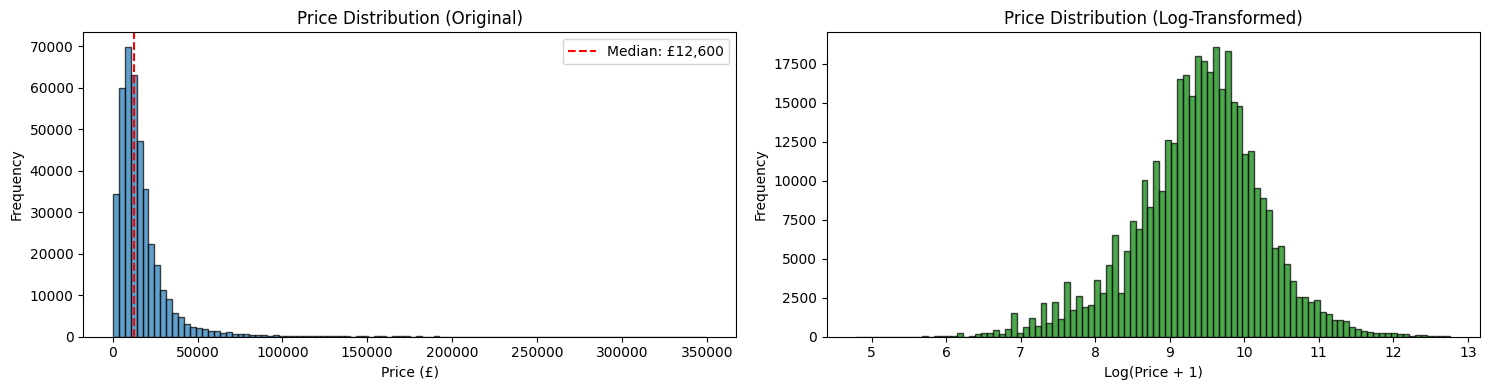

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Original price
axes[0].hist(df['price'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price (£)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution (Original)')
axes[0].axvline(df['price'].median(), color='r', linestyle='--',
                label=f'Median: £{df["price"].median():,.0f}')
axes[0].legend()

# Log-transformed
axes[1].hist(np.log1p(df['price']), bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution (Log-Transformed)')

plt.tight_layout()
plt.show()

## Identify Numeric Features analysis and change

***Removing Old Cars*** :

* While data points such as a 1969 Land Rover Series II were identified as valid (not noise), they were removed as outliers. These vintage vehicles follow a different valuation logic (appreciating assets) compared to the standard modern vehicle market. Including them would introduce non-linearity that could degrade the performance of the Linear Regression model.
* Any car befor 1886 is definitly noise since it is the date first car was ever made.

***Get rid of cars with high mileage*** :

* Some cars have almost wrong millage they set records more than the most driven car in the world.
* little few cars have a milage thats high (Taxis) and they can be counted but at the same time including them will be be unbenificial since taxis ads is limited espically after uber there is no need to buy a taxi to work in a cab.

In [12]:
num_feat = ['age', 'mileage']

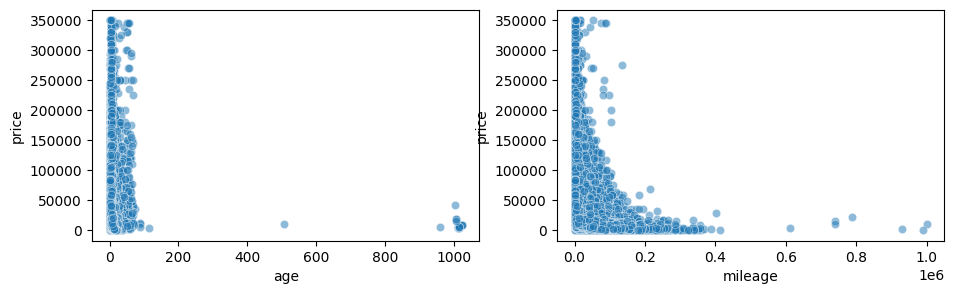

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=len(num_feat), figsize=(11,3))
for i in range(len(num_feat)):
  sns.scatterplot(data=df, x=num_feat[i-1], y='price', alpha=0.5, ax=axs[i-1])

In [14]:
price_cap = 350000
mileage_cap = 300000 # Excludes taxis/errors
age_cap = 33 # Exclude vintage cars

df_clean = df[
    # (df['price'] < price_cap) &
    (df['mileage'] < mileage_cap) &
    (df['age'] <= age_cap)
].copy()

# Print how much data was lost
lost_data = len(df) - len(df_clean)
print(f"Removed {lost_data} rows ({(lost_data/len(df))*100:.2f}%) as outliers.")
df = df_clean

Removed 813 rows (0.20%) as outliers.


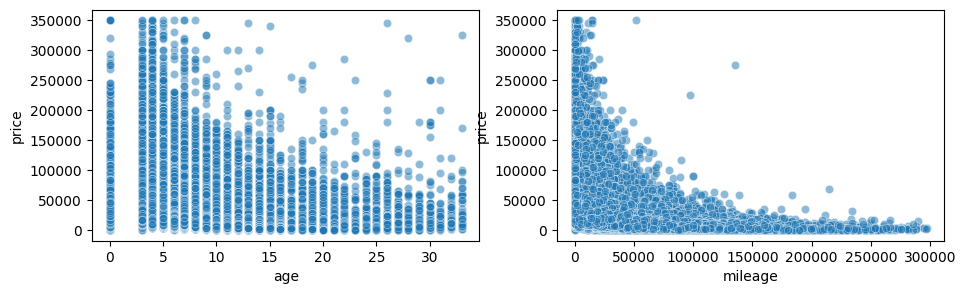

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=len(num_feat), figsize=(11,3))
for i in range(len(num_feat)):
  sns.scatterplot(data=df, x=num_feat[i-1], y='price', alpha=0.5, ax=axs[i-1])

## Get new prestige Feature out of the Car standard_make

In [16]:
def get_brand_prestige_class(brand):

    prestige_map = {
        # Class 5: Exotic/Hypercar (£150k+)
        'Ferrari': 5, 'Lamborghini': 5, 'McLaren': 5, 'Bugatti': 5, 'Pagani': 5,

        # Class 4: Ultra-Luxury (£95k)
        'Bentley': 4, 'Rolls-Royce': 4, 'Maybach': 4, 'Daimler': 4, 'BAC': 4,

        # Class 3: Luxury (£40k)
        'Jaguar': 3, 'Land Rover': 3, 'Porsche': 3, 'Maserati': 3, 'Aston Martin': 3, 'Lotus': 3, 'TVR': 3,
        'Morgan': 3, 'Caterham': 3, 'Noble': 3, 'Ariel': 3, 'Alpine': 3, 'Corvette': 3, 'Hummer': 3, 'Radical': 3,
        'Ultima': 3, 'AC': 3, 'Bristol': 3, 'Jensen': 3, 'Triumph': 3,

        # Class 2: Premium/Near-Luxury (£20k)
        'Audi': 2, 'BMW': 2, 'Mercedes-Benz': 2, 'Volkswagen': 2, 'MINI': 2, 'Volvo': 2, 'Lexus': 2,
        'Alfa Romeo': 2, 'Subaru': 2, 'Infiniti': 2, 'Tesla': 2, 'Abarth': 2, 'Cadillac': 2, 'Lincoln': 2,
        'Saab': 2, 'Lancia': 2, 'Chrysler': 2, 'Buick': 2, 'Westfield': 2, 'Zenos': 2,

        # Class 1: Budget + Mass Market (£10k) - ALL OTHERS

        # Budget brands
        'Dacia': 1, 'Perodua': 1, 'Proton': 1, 'SsangYong': 1, 'Daewoo': 1, 'Great Wall': 1, 'Rover': 1,
        'MG': 1, 'Suzuki': 1, 'Daihatsu': 1, 'Datsun': 1, 'Aixam': 1, 'Reliant': 1,
        # Mass market brands
        'Vauxhall': 1, 'SKODA': 1, 'SEAT': 1, 'Peugeot': 1, 'Citroen': 1, 'Renault': 1, 'Fiat': 1, 'Kia': 1,
        'Hyundai': 1, 'Nissan': 1, 'Toyota': 1, 'Honda': 1, 'Mazda': 1, 'Mitsubishi': 1, 'Ford': 1,
        'Chevrolet': 1, 'Opel': 1, 'Smart': 1, 'DS AUTOMOBILES': 1, 'CUPRA': 1, 'Jeep': 1, 'Dodge': 1,
        'GMC': 1, 'Isuzu': 1, 'Pontiac': 1, 'Plymouth': 1, 'Holden': 1, 'International': 1,
        # Commercial/Taxi
        'London Taxis International': 1, 'LEVC': 1, 'Carbodies': 1, 'Iveco': 1,
        # Classic/Kit cars (lower value)
        'Panther': 1, 'Replica': 1, 'Custom Vehicle': 1, 'Dax': 1, 'Tiger': 1, 'Pilgrim': 1, 'Mev': 1,
        'Beauford': 1, 'Sebring': 1, 'Gentry': 1, 'AK': 1, 'Mitsuoka': 1, 'Austin': 1, 'Morris': 1,
        'Leyland': 1, 'Wolseley': 1,
    }

    return prestige_map.get(brand, 1)

In [17]:
df['brand_prestige'] = df['standard_make'].apply(get_brand_prestige_class)

In [18]:
print(df.groupby('brand_prestige')['price'].agg(['count', 'mean', 'median']).round(0))

                 count      mean    median
brand_prestige                            
1               201227   10945.0    9499.0
2               169323   18975.0   15990.0
3                27864   37029.0   29995.0
4                 1310   94477.0   79993.0
5                 1323  150807.0  144950.0


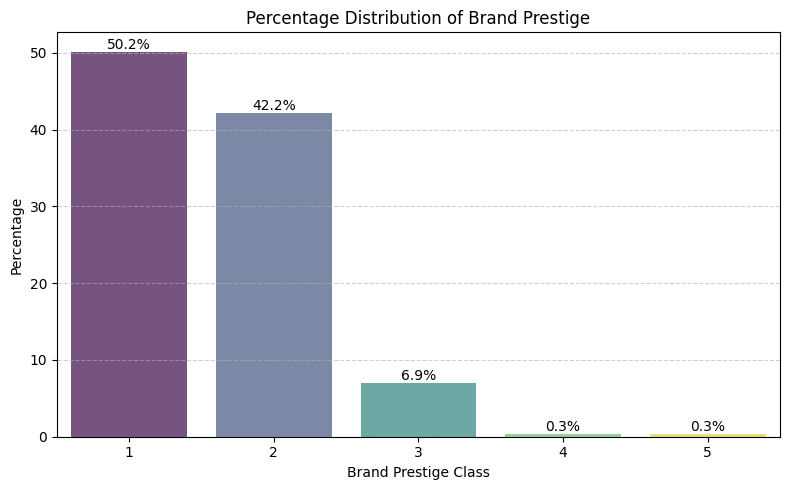

In [19]:
# 1. Percentage Distribution for brand_prestige
plt.figure(figsize=(8, 5))
percentages_prestige = df['brand_prestige'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
percentages_prestige.columns = ['brand_prestige', 'percent']
sns.barplot(data=percentages_prestige, x='brand_prestige', y='percent', hue='brand_prestige', alpha=0.7, palette='viridis', legend=False)
plt.title('Percentage Distribution of Brand Prestige')
plt.xlabel('Brand Prestige Class')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

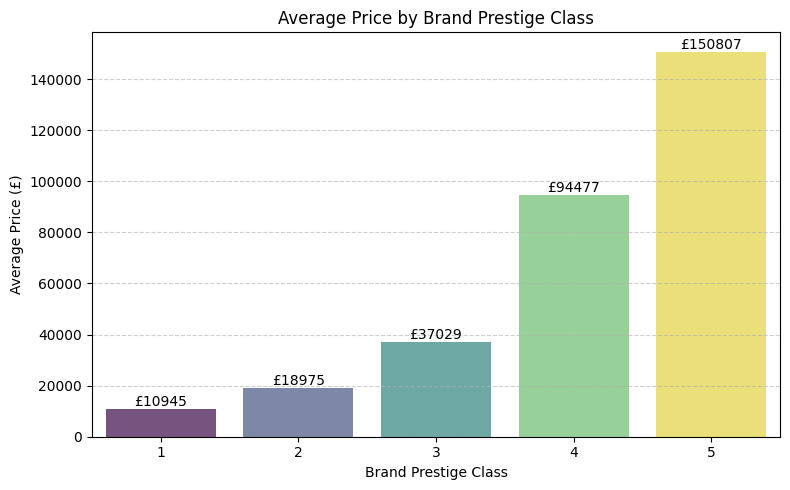

In [20]:
# 1. Average Price per Brand Prestige Class
plt.figure(figsize=(8, 5))
mean_price_prestige = df.groupby('brand_prestige')['price'].mean().reset_index()
sns.barplot(data=mean_price_prestige, x='brand_prestige', y='price', hue='brand_prestige', alpha=0.7, palette='viridis', legend=False)
plt.title('Average Price by Brand Prestige Class')
plt.xlabel('Brand Prestige Class')
plt.ylabel('Average Price (£)')
plt.xticks(rotation=0)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='£%.0f')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Identify Categorical Features analysis and change

Minimize the dimentions on the categorical feature.


*   Currently we have allot of categorical features most of them is have very little to no real representation so we will have the top(n) feature of each feature.
*   All features that are not in the top(n) will be added under single one feature named "feature_name_other".
*   Sometimes the new (other) feature will becom more represented than other brand and thats totally fine it's called the tail effect allot of small chunks adds up if the percentage is under 60 thats totally normal espically for a feature like "standard_make".

**End results is**
1.  Keep top 20 Brands
2.  Keep top 10 Colors
3.  Keep top 8 Body Types
4.  Keep top 4 (Petrol, Diesel, Hybrid, Electric)
5. Everything that is not on top will be other

In [21]:
df['crossover_car_and_van'] = df['crossover_car_and_van'].astype(int)
df['crossover_car_and_van'].value_counts(normalize=True)

,proportion
crossover_car_and_van,
0,0.995599
1,0.004401


In [22]:
# Drop 'crossover_car_and_van' due to near-zero variance (<0.5% positive class)
df.drop(columns=['crossover_car_and_van'], inplace=True, errors='ignore')

In [23]:
categorical_feat = ['standard_colour', 'standard_make',
                    'vehicle_condition', 'body_type','fuel_type']

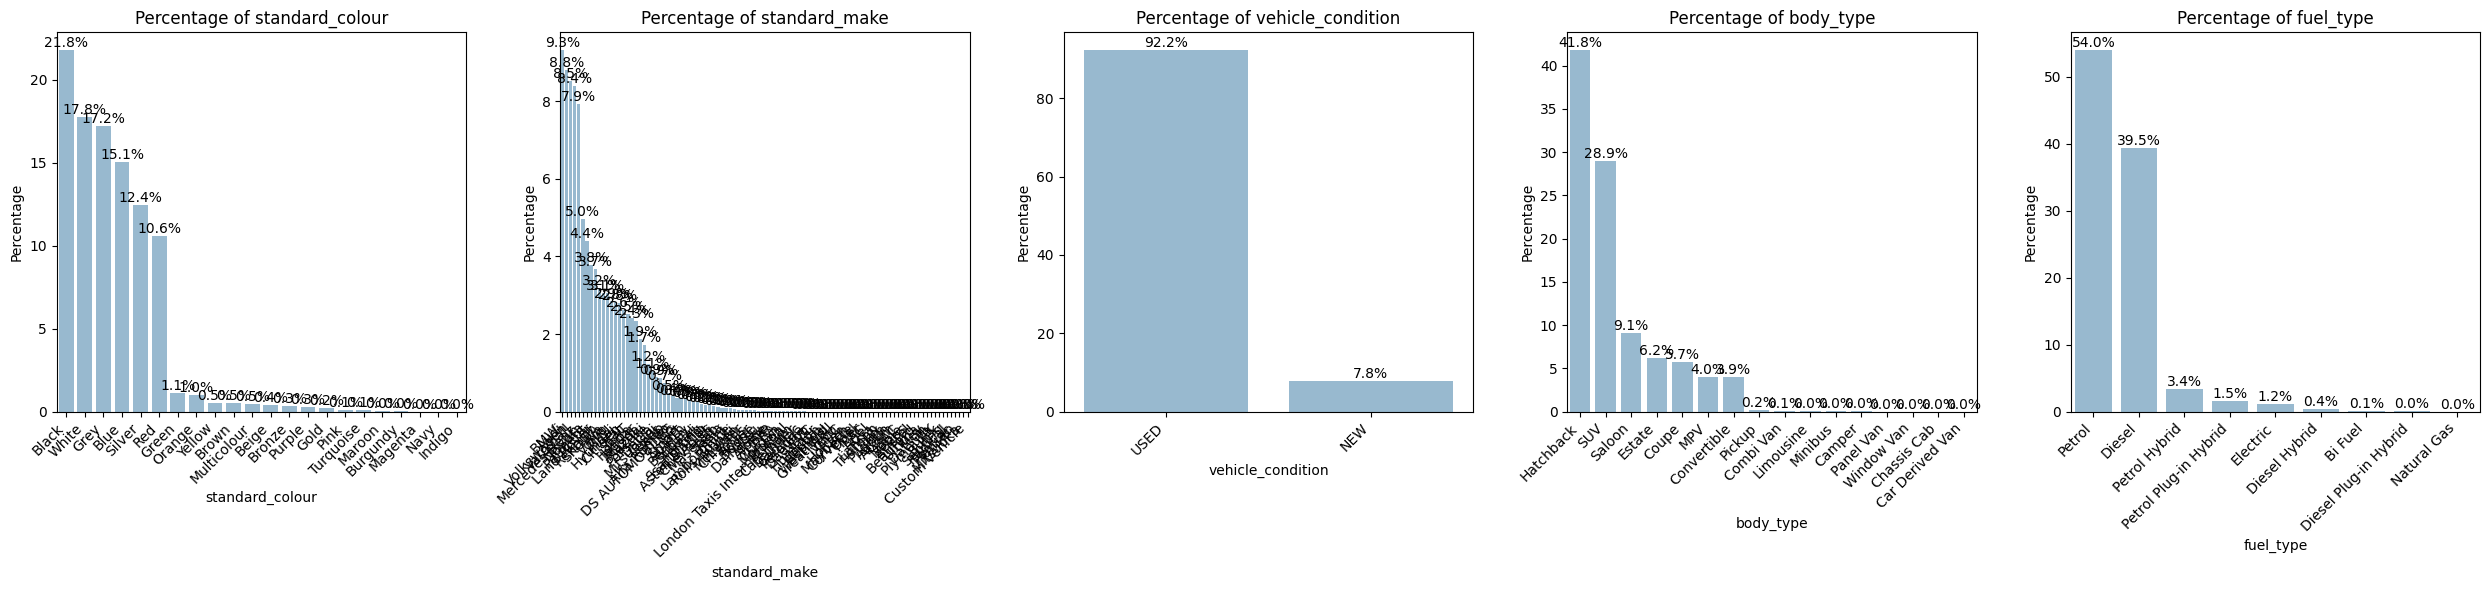

In [24]:
def printCountCategorical():
  num_cols = len(categorical_feat)
  fig, axs = plt.subplots(nrows=1, ncols=num_cols, figsize=(5 * num_cols, 6))
  axs = axs.flatten() # Flatten the 2D array of axes into a 1D array for easier iteration

  for i in range(len(categorical_feat)):
    # Calculate percentage for each category
    percentages = df[categorical_feat[i]].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    percentages.columns = [categorical_feat[i], 'percent'] # Rename columns for clarity

    # Create a bar plot using percentages
    sns.barplot(data=percentages, x=categorical_feat[i], y='percent', alpha=0.5, ax=axs[i])
    axs[i].set_title(f'Percentage of {categorical_feat[i]}') # Updated title
    axs[i].set_ylabel('Percentage') # Set y-axis label to Percentage
    axs[i].set_xticks(axs[i].get_xticks())
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right') # Rotate labels

    # Add percentage labels on top of bars
    for container in axs[i].containers:
        axs[i].bar_label(container, fmt='%.1f%%')

  plt.tight_layout()
  plt.show()

# call function
printCountCategorical()

In [25]:
def clean_categorical(df, column, top_n=10):
    # Find the top N most frequent categories
    top_categories = df[column].value_counts().nlargest(top_n).index

    # Overwrite the column: keep top_n values, replace others with 'Other'
    df[column] = df[column].where(df[column].isin(top_categories), other='Other')

    print(f"Cleaned '{column}': now has {df[column].nunique()} unique categories.")

In [26]:
clean_categorical(df, 'standard_colour', top_n=10) # Keep top 10 Colors
clean_categorical(df, 'body_type', top_n=8)        # Keep top 8 Body Types
clean_categorical(df, 'fuel_type', top_n=4)        # Keep top 4 (Petrol, Diesel, Hybrid, Electric)
clean_categorical(df, 'standard_make', top_n=20)   # Keep top 20 Brands

Cleaned 'standard_colour': now has 11 unique categories.
Cleaned 'body_type': now has 9 unique categories.
Cleaned 'fuel_type': now has 5 unique categories.
Cleaned 'standard_make': now has 21 unique categories.


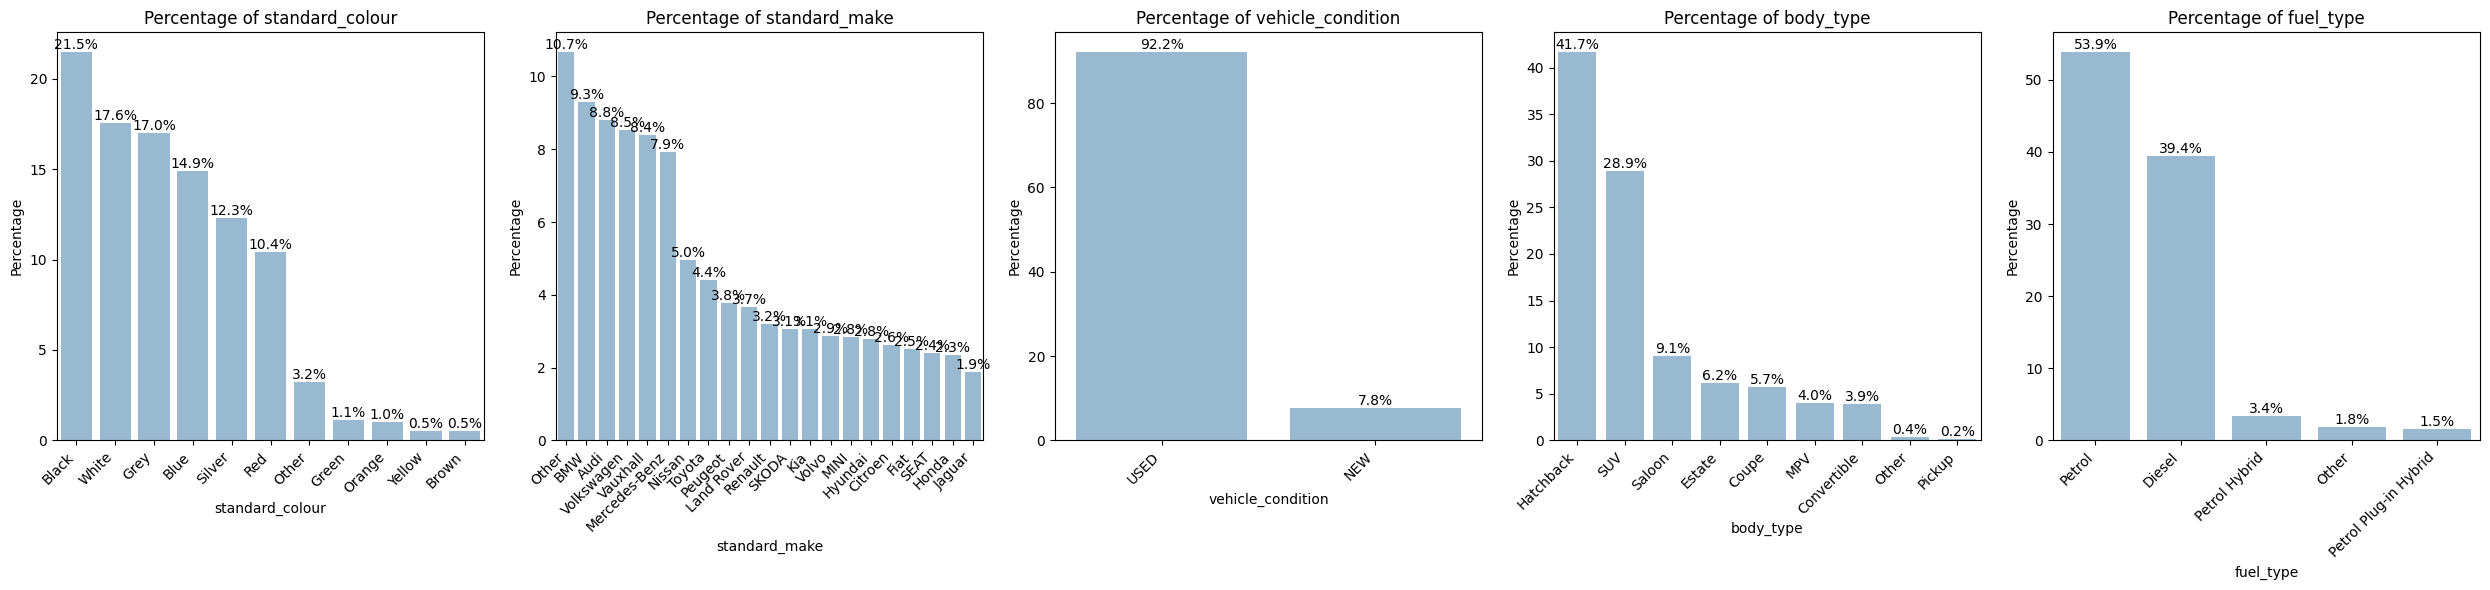

In [27]:
printCountCategorical()

# Prepare Machine Learning Models

## Hot Incoding for features

In [28]:
df.shape

(401047, 9)

In [29]:
df.keys()

Index(['mileage', 'standard_colour', 'standard_make', 'vehicle_condition',
       'price', 'body_type', 'fuel_type', 'age', 'brand_prestige'],
      dtype='object')

In [30]:
ohe = OneHotEncoder(handle_unknown='ignore')

# Encode on categorical columns
df = pd.get_dummies(data=df, dtype=int)

# Display DataFrame shape
df.shape

(401047, 52)

In [31]:
df.keys()

Index(['mileage', 'price', 'age', 'brand_prestige', 'standard_colour_Black',
       'standard_colour_Blue', 'standard_colour_Brown',
       'standard_colour_Green', 'standard_colour_Grey',
       'standard_colour_Orange', 'standard_colour_Other',
       'standard_colour_Red', 'standard_colour_Silver',
       'standard_colour_White', 'standard_colour_Yellow', 'standard_make_Audi',
       'standard_make_BMW', 'standard_make_Citroen', 'standard_make_Fiat',
       'standard_make_Honda', 'standard_make_Hyundai', 'standard_make_Jaguar',
       'standard_make_Kia', 'standard_make_Land Rover', 'standard_make_MINI',
       'standard_make_Mercedes-Benz', 'standard_make_Nissan',
       'standard_make_Other', 'standard_make_Peugeot', 'standard_make_Renault',
       'standard_make_SEAT', 'standard_make_SKODA', 'standard_make_Toyota',
       'standard_make_Vauxhall', 'standard_make_Volkswagen',
       'standard_make_Volvo', 'vehicle_condition_NEW',
       'vehicle_condition_USED', 'body_type_Convert

Avoid Multicolinearity

In [32]:
df.drop(['standard_colour_Yellow','standard_make_Renault','vehicle_condition_NEW','body_type_Convertible','fuel_type_Petrol Plug-in Hybrid'],axis=1, inplace=True)

In [33]:
df.head(3)

,mileage,price,age,brand_prestige,standard_colour_Black,standard_colour_Blue,standard_colour_Brown,standard_colour_Green,standard_colour_Grey,standard_colour_Orange,...,body_type_Hatchback,body_type_MPV,body_type_Other,body_type_Pickup,body_type_SUV,body_type_Saloon,fuel_type_Diesel,fuel_type_Other,fuel_type_Petrol,fuel_type_Petrol Hybrid
0,0.0,73970,0.0,2,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,108230.0,7000,12.0,3,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,7800.0,14000,6.0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


## Preparing The Split

In [34]:
# Take the log1p of the price
y = np.log1p(df['price'])
X = df.drop('price', axis=1)

seed = 7

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    # train_size=0.10,
    # test_size=0.02,
    test_size = 0.2,
    random_state=seed,
    stratify=df['brand_prestige'] ## TODO: figure out what is this
)

print("X_train shape: ", X_train.shape, "; y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape, "; y_test shape: ", y_test.shape)

X_train shape:  (320837, 46) ; y_train shape:  (320837,)
X_test shape:  (80210, 46) ; y_test shape:  (80210,)


## Scaler on train and test

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# FIT on Training data only, then TRANSFORM both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame (optional, keeps column names for analysis later)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

## Cross Valdation

In [37]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [38]:
models = []
models.append(('LinReg', LinearRegression()))
# models.append(('kNN', KNeighborsRegressor(n_neighbors=23, weights='distance', metric='manhattan', n_jobs=-1)))
models.append(('DT', DecisionTreeRegressor(random_state=42,min_samples_split=100,min_samples_leaf=10,max_depth=20)))

seed = 42
np.random.seed(seed)

names = []
results = []

print("Model Evaluation (R2 Score):")
print("-" * 30)

for name, model in models:
    k_fold = model_selection.KFold(n_splits=5, shuffle=True, random_state=seed)

    cv_results = model_selection.cross_val_score(
        model, X_train_scaled, y_train, cv=k_fold, scoring="r2"
    )

    results.append(cv_results)
    names.append(name)

    # Print mean score and standard deviation
    print(f"{name}: {cv_results.mean():.3f} (Std: {cv_results.std():.3f})")

Model Evaluation (R2 Score):
------------------------------
LinReg: 0.852 (Std: 0.001)
DT: 0.892 (Std: 0.001)


/tmp/ipython-input-4057337144.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results,labels=names)


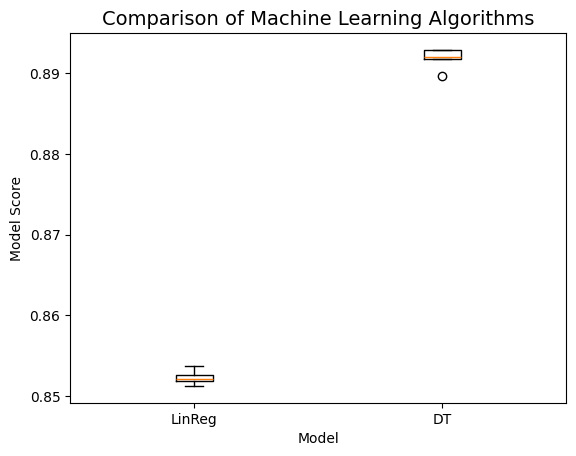

In [39]:
plt.boxplot(results,labels=names)
plt.title('Comparison of Machine Learning Algorithms',fontsize=14)
plt.gca().set(ylabel='Model Score', xlabel='Model')
plt.show()

## Test Para

##### Models Parameters Optimaiztion will be run to get best set of parameters for each model

In [40]:
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import RandomizedSearchCV
# import numpy as np

# # 1. Define Parameter Grid
# # 'alpha' is the tuning parameter.
# # alpha=0 is the same as normal Linear Regression.
# # High alpha (e.g., 100) forces the model to be simpler (less overfitting).
# param_dist = {
#     'alpha': [200,225,250,275,300]
# }

# # 2. Setup Search
# ridge_search = RandomizedSearchCV(
#     Ridge(random_state=42),
#     param_distributions=param_dist,
#     n_iter=5,         # Check all 9 values above
#     cv=5,             # 5-fold Cross Validation
#     scoring='r2',
#     n_jobs=-1,        # Use all processors
#     random_state=42
# )

# print("Tuning Ridge Regression (Regularized Linear Model)...")
# ridge_search.fit(X_train_scaled, y_train)

# print(f"Best Alpha: {ridge_search.best_params_['alpha']}")
# print(f"Best Ridge Score (CV): {ridge_search.best_score_:.3f}")

# # 3. Final Validation vs Baseline
# best_ridge = ridge_search.best_estimator_
# print(f"Final Ridge Score on Test Set: {best_ridge.score(X_test_scaled, y_test):.3f}")

In [41]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import RandomizedSearchCV

# # 1. Define the Parameter Grid
# # We restrict the tree to stop it from growing infinitely deep
# param_dist = {
#     'max_depth': [10, 15, 20, 30],         # Limit depth to prevent overfitting
#     'min_samples_leaf': [10, 20, 50, 100], # Require multiple cars in a "leaf" to make a rule
#     'min_samples_split': [20, 50, 100]     # Don't split unless you have enough data
# }

# # 2. Setup Randomized Search
# dt_search = RandomizedSearchCV(
#     DecisionTreeRegressor(random_state=42),
#     param_distributions=param_dist,
#     n_iter=20,        # Test 20 combinations
#     cv=5,             # 5-fold Cross Validation
#     scoring='r2',     # Maximize R2
#     n_jobs=-1,
#     random_state=42
# )

# print("Tuning Decision Tree (fixing overfitting)...")
# dt_search.fit(X_train_scaled, y_train)

# print(f"Best DT Parameters: {dt_search.best_params_}")
# print(f"Best DT Score (CV): {dt_search.best_score_:.3f}")

In [42]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.neighbors import KNeighborsRegressor
# import numpy as np

# # 1. Setup the parameter grid
# # We test 'k' from 3 to 25
# # We test 'weights' (uniform vs distance)
# param_grid = {
#     'n_neighbors': np.arange(3, 26, 2),  # [3, 5, 7, ..., 25]
#     'weights': ['uniform', 'distance'],  # Key improvement
#     'metric': ['euclidean', 'manhattan'] # Manhattan often works better for high dimensions
# }

# # 2. Configure Randomized Search (Faster than Grid Search)
# knn_search = RandomizedSearchCV(
#     KNeighborsRegressor(n_jobs=-1),
#     param_distributions=param_grid,
#     n_iter=20,        # Test 20 random combinations
#     cv=3,             # 3-fold CV for speed
#     scoring='r2',     # Maximize R2 score
#     random_state=42,
#     n_jobs=-1,
#     verbose=1
# )

# # 3. Train on a subset first (to save time)
# # Using 20% of training data for tuning is a valid strategy mentioned in specs
# X_tune = X_train_scaled[:20000]
# y_tune = y_train[:20000]

# print("Tuning kNN parameters...")
# knn_search.fit(X_tune, y_tune)

# print(f"Best Parameters: {knn_search.best_params_}")
# print(f"Best Tuning Score: {knn_search.best_score_:.3f}")

# # 4. Final Validation
# # Plug the best parameters into the full model
# best_k = knn_search.best_params_['n_neighbors']
# best_weight = knn_search.best_params_['weights']
# best_metric = knn_search.best_params_['metric']

# final_knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weight, metric=best_metric, n_jobs=-1)
# final_knn.fit(X_train_scaled, y_train)
# print(f"Final kNN Score on Test Set: {final_knn.score(X_test_scaled, y_test):.3f}")

## Train Model

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [44]:
final_model = DecisionTreeRegressor(
    max_depth=20,
    min_samples_leaf=10,
    min_samples_split=100,
    random_state=42,
)

In [45]:
sample_weights_full = df['brand_prestige'].map({
    1: 1.0,
    2: 1.0,
    3: 1.0,   # No boost for luxury (28k is enough data)
    4: 2.5,   # Focus here - ultra-luxury
    5: 3.0
})

# Fit the model
final_model.fit(X_train_scaled, y_train,sample_weight=sample_weights_full.loc[X_train.index])

DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, min_samples_split=100,
                      random_state=42)

In [46]:
y_pred_log = final_model.predict(X_test_scaled)

### Visualize Trainning Results

In [47]:
y_pred_log = final_model.predict(X_test_scaled)
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)

y_pred_train_log = final_model.predict(X_train_scaled)
y_train_real = np.expm1(y_train)
y_pred_train_real = np.expm1(y_pred_train_log)

# SCORING
r2_final_log_test = r2_score(y_test, y_pred_log)
r2_final_real_test = r2_score(y_test_real, y_pred_real)
mae_final_real_test = mean_absolute_error(y_test_real, y_pred_real)

r2_final_log_train = r2_score(y_train, y_pred_train_log)
r2_final_real_train = r2_score(y_train_real, y_pred_train_real)
mae_final_real_train = mean_absolute_error(y_train_real, y_pred_train_real)

print(f"--- FINAL TEST RESULTS ---")
print(f"R2 Score (Log-transformed, Test): {r2_final_log_test:.4f}")
print(f"R2 Score (Real Prices, Test): {r2_final_real_test:.4f}")
print(f"MAE (Test): £{mae_final_real_test:.2f} (Average error per car in real prices)")

print(f"\n--- FINAL TRAIN RESULTS ---")
print(f"R2 Score (Log-transformed, Train): {r2_final_log_train:.4f}")
print(f"R2 Score (Real Prices, Train): {r2_final_real_train:.4f}")
print(f"MAE (Train): £{mae_final_real_train:.2f} (Average error per car in real prices)")

--- FINAL TEST RESULTS ---
R2 Score (Log-transformed, Test): 0.8943
R2 Score (Real Prices, Test): 0.8089
MAE (Test): £3354.55 (Average error per car in real prices)

--- FINAL TRAIN RESULTS ---
R2 Score (Log-transformed, Train): 0.9063
R2 Score (Real Prices, Train): 0.8233
MAE (Train): £3216.26 (Average error per car in real prices)


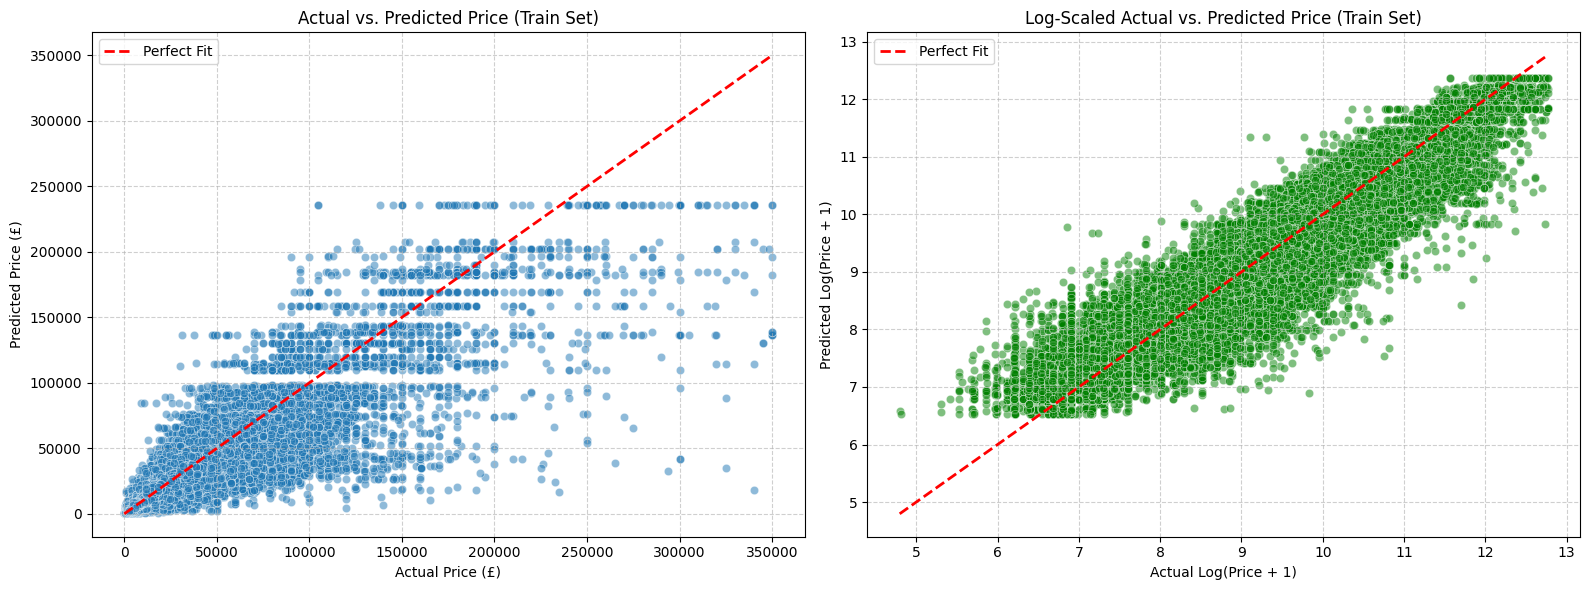

In [48]:
plt.figure(figsize=(16, 6))

# Plot 1: Actual vs. Predicted Price (Real Scale, Train Set)
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_real, y=y_pred_train_real, alpha=0.5, color='#1f77b4')

min_val_real = min(y_train_real.min(), y_pred_train_real.min())
max_val_real = max(y_train_real.max(), y_pred_train_real.max())
plt.plot([min_val_real, max_val_real], [min_val_real, max_val_real], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Actual vs. Predicted Price (Train Set)')
plt.xlabel('Actual Price (£)')
plt.ylabel('Predicted Price (£)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Log-Scaled Actual vs. Predicted Price (Training Set)
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_train, y=y_pred_train_log, alpha=0.5, color='green')

min_val_log = min(y_train.min(), y_pred_train_log.min())
max_val_log = max(y_train.max(), y_pred_train_log.max())
plt.plot([min_val_log, max_val_log], [min_val_log, max_val_log], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Log-Scaled Actual vs. Predicted Price (Train Set)')
plt.xlabel('Actual Log(Price + 1)')
plt.ylabel('Predicted Log(Price + 1)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

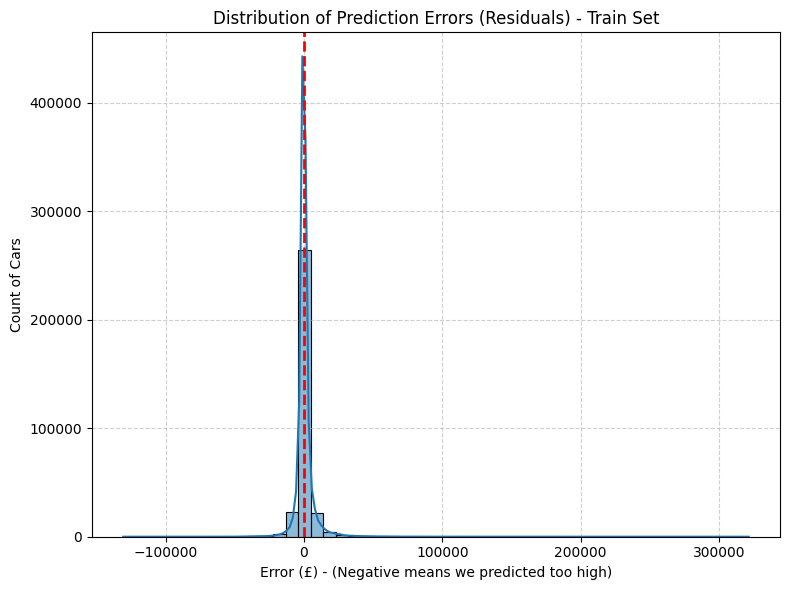

In [49]:
residuals_train = y_train_real - y_pred_train_real

plt.figure(figsize=(8, 6))
sns.histplot(residuals_train, kde=True, color='#1f77b4', bins=50)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Distribution of Prediction Errors (Residuals) - Train Set')
plt.xlabel('Error (£) - (Negative means we predicted too high)')
plt.ylabel('Count of Cars')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

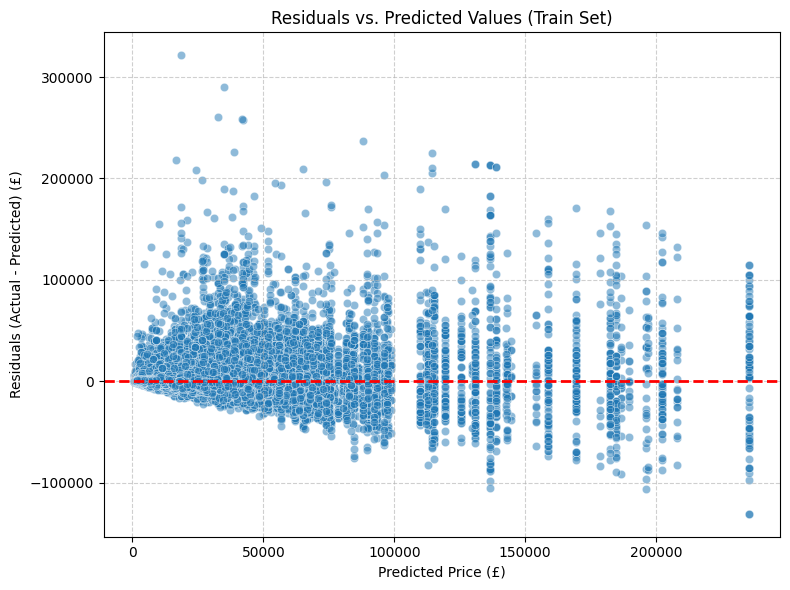

In [50]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_train_real, y=residuals_train, alpha=0.5, color='#1f77b4')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')

plt.title('Residuals vs. Predicted Values (Train Set)')
plt.xlabel('Predicted Price (£)')
plt.ylabel('Residuals (Actual - Predicted) (£)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

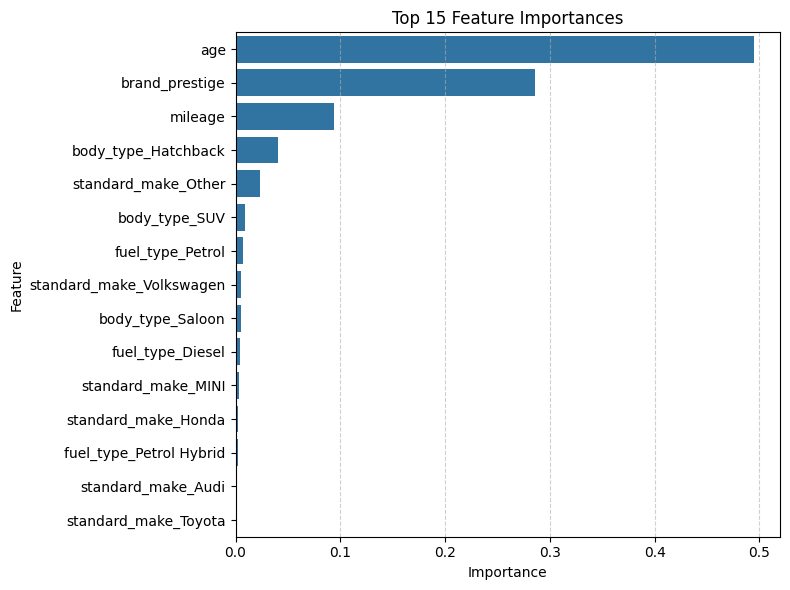

In [51]:
feature_names = X_train_scaled.columns
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), color='#1f77b4') # Top 15 features
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [52]:
# 1. Create a DataFrame of Actual vs Predicted
results_df = pd.DataFrame({
    'Actual_Price': y_test_real,
    'Predicted_Price': y_pred_real
})

# 2. Calculate the Absolute Error
results_df['Error'] = np.abs(results_df['Actual_Price'] - results_df['Predicted_Price'])

# 3. Sort by biggest error
worst_failures = results_df.sort_values(by='Error', ascending=False).head(10)

print("--- Top 5 Worst Model Failures ---")
print(worst_failures)

# Optional: If you still have the full X_test, join it to see the Car Brand/Year
# (Assuming indices match X_test_original if you have it, otherwise just analyze the prices)

--- Top 5 Worst Model Failures ---
        Actual_Price  Predicted_Price          Error
246904      349975.0     84598.334655  265376.665345
159014      329900.0     90000.398134  239899.601866
268102      249950.0     16491.751500  233458.248500
166945      345000.0    136432.984372  208567.015628
35911       259950.0     60385.281873  199564.718127
229190      225675.0     31430.853031  194244.146969
41641       250000.0     56793.442806  193206.557194
41659       274950.0     84598.334655  190351.665345
339133      319995.0    130668.465853  189326.534147
276353      325500.0    138856.396099  186643.603901
